<a href="https://colab.research.google.com/github/affan1317/GEOL0069-EOYA/blob/main/Sentinel_3_Altimetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install required packages. The session might need to be restarted after installation.

In [1]:
!pip install rasterio
!pip install netCDF4
!pip install cartopy
!pip install basemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
import numpy.ma as ma
import glob
from matplotlib.patches import Polygon
import scipy.spatial as spatial
from scipy.spatial import KDTree

import pyproj
import cartopy.crs as ccrs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster

Read in the functions needed, extracting and processing the desired data from the raw altimetry data.

In [3]:
#=========================================================================================================
#===================================  SUBFUNCTIONS  ======================================================
#=========================================================================================================

#*args and **kwargs allow you to pass an unspecified number of arguments to a function,
#so when writing the function definition, you do not need to know how many arguments will be passed to your function
#**kwargs allows you to pass keyworded variable length of arguments to a function.
#You should use **kwargs if you want to handle named arguments in a function.
#double star allows us to pass through keyword arguments (and any number of them).
def peakiness(waves, **kwargs):

    "finds peakiness of waveforms."

    #print("Beginning peakiness")
    # Kwargs are:
    #          wf_plots. specify a number n: wf_plots=n, to show the first n waveform plots. \

    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import time

    print("Running peakiness function...")

    size=np.shape(waves)[0] #.shape property is a tuple of length .ndim containing the length of each dimensions
                            #Tuple of array dimensions.

    waves1=np.copy(waves)

    if waves1.ndim == 1: #number of array dimensions
        print('only one waveform in file')
        waves2=waves1.reshape(1,np.size(waves1)) #numpy.reshape(a, newshape, order='C'), a=array to be reshaped
        waves1=waves2

    # *args is used to send a non-keyworded variable length argument list to the function
    def by_row(waves, *args):
        "calculate peakiness for each waveform"
        maximum=np.nanmax(waves)
        if maximum > 0:

            maximum_bin=np.where(waves==maximum)
            #print(maximum_bin)
            maximum_bin=maximum_bin[0][0]
            waves_128=waves[maximum_bin-50:maximum_bin+78]

            waves=waves_128

            noise_floor=np.nanmean(waves[10:20])
            where_above_nf=np.where(waves > noise_floor)

            if np.shape(where_above_nf)[1] > 0:
                maximum=np.nanmax(waves[where_above_nf])
                total=np.sum(waves[where_above_nf])
                mean=np.nanmean(waves[where_above_nf])
                peaky=maximum/mean

            else:
                peaky = np.nan
                maximum = np.nan
                total = np.nan

        else:
            peaky = np.nan
            maximum = np.nan
            total = np.nan

        if 'maxs' in args:
            return maximum
        if 'totals' in args:
            return total
        if 'peaky' in args:
            return peaky

    peaky=np.apply_along_axis(by_row, 1, waves1, 'peaky') #numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)

    if 'wf_plots' in kwargs:
        maximums=np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals=np.apply_along_axis(by_row, 1, waves1, 'totals')

        for i in range(0,kwargs['wf_plots']):
            if i == 0:
                print("Plotting first "+str(kwargs['wf_plots'])+" waveforms")

            plt.plot(waves1[i,:])#, a, col[i],label=label[i])
            plt.axhline(maximums[i], color='green')
            plt.axvline(10, color='r')
            plt.axvline(19, color='r')
            plt.xlabel('Bin (of 256)')
            plt.ylabel('Power')
            plt.text(5,maximums[i],"maximum="+str(maximums[i]))
            plt.text(5,maximums[i]-2500,"total="+str(totals[i]))
            plt.text(5,maximums[i]-5000,"peakiness="+str(peaky[i]))
            plt.title('waveform '+str(i)+' of '+str(size)+'\n. Noise floor average taken between red lines.')
            plt.show()


    return peaky

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================


def unpack_gpod(variable):

    from scipy.interpolate import interp1d

    time_1hz=SAR_data.variables['time_01'][:]
    time_20hz=SAR_data.variables['time_20_ku'][:]
    time_20hzC = SAR_data.variables['time_20_c'][:]

    out=(SAR_data.variables[variable][:]).astype(float)  # convert from integer array to float.

    #if ma.is_masked(dataset.variables[variable][:]) == True:
    #print(variable,'is masked. Removing mask and replacing masked values with nan')
    out=np.ma.filled(out, np.nan)

    if len(out)==len(time_1hz):

        print(variable,'is 1hz. Expanding to 20hz...')
        out = interp1d(time_1hz,out,fill_value="extrapolate")(time_20hz)

    if len(out)==len(time_20hzC):
        print(variable, 'is c band, expanding to 20hz ku band dimension')
        out = interp1d(time_20hzC,out,fill_value="extrapolate")(time_20hz)
    return out


#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

def calculate_SSD(RIP):

    from scipy.optimize import curve_fit
    from scipy import asarray as ar,exp
    do_plot='Off'

    def gaussian(x,a,x0,sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

    SSD=np.zeros(np.shape(RIP)[0])*np.nan
    x=np.arange(np.shape(RIP)[1])

    for i in range(np.shape(RIP)[0]):

        y=np.copy(RIP[i])
        y[(np.isnan(y)==True)]=0

        if 'popt' in locals():
            del(popt,pcov)

        SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
        #print('SSD calculated from equation',SSD)

        #n = len(x)
        mean_est = sum(x * y) / sum(y)
        sigma_est = np.sqrt(sum(y * (x - mean_est)**2) / sum(y))
        #print('est. mean',mean,'est. sigma',sigma_est)

        try:
            popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean_est, sigma_est],maxfev=10000)
        except RuntimeError as e:
            print("Gaussian SSD curve-fit error: "+str(e))
            #plt.plot(y)
            #plt.show()

        except TypeError as t:
            print("Gaussian SSD curve-fit error: "+str(t))

        if do_plot=='ON':

            plt.plot(x,y)
            plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
            plt.axvline(popt[1])
            plt.axvspan(popt[1]-popt[2], popt[1]+popt[2], alpha=0.15, color='Navy')
            plt.show()

            print('popt',popt)
            print('curve fit SSD',popt[2])

        if 'popt' in locals():
            SSD[i]=abs(popt[2])


    return SSD

In [4]:
path = '/content/drive/MyDrive/GEOL0069/EOYA/'    # Define path to data
SAR_file = 'S3B_SR_2_LAN_SI_20240304T154612_20240304T160309_20240328T201933_1016_090_211______PS2_O_NT_005.SEN3' # change accordingly
print('overlapping SAR file is',SAR_file)
SAR_data = Dataset(path + SAR_file + '/enhanced_measurement.nc')

SAR_lat, SAR_lon, waves, sig_0, RIP, flag= unpack_gpod('lat_20_ku'), unpack_gpod('lon_20_ku'), unpack_gpod('waveform_20_ku'),unpack_gpod('sig0_water_20_ku'),unpack_gpod('rip_20_ku'), unpack_gpod('surf_type_class_20_ku') #unpack_gpod('Sigma0_20Hz')
SAR_index=np.arange(np.size(SAR_lat))    # Extract the desired variables using the defined function

find=np.where(SAR_lat >= -99999)  # 60
SAR_lat=SAR_lat[find]             # lat_20_ku
SAR_lon=SAR_lon[find]             # lon_20_ku
SAR_index=SAR_index[find]
waves=waves[find]                 # waveform_20_k
sig_0=sig_0[find]                 # sig0_water_20_ku
RIP=RIP[find]                     # rip_20_k
flag=flag[find]                   # surf_type_class_20_ku

PP=peakiness(waves)
SSD=calculate_SSD(RIP)

sig_0_np = np.array(sig_0)
RIP_np = np.array(RIP)
PP_np = np.array(PP)
SSD_np = np.array(SSD)

data = np.column_stack((sig_0_np,PP_np, SSD_np))    # variables used for classification
# Standardize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

overlapping SAR file is S3B_SR_2_LAN_SI_20240304T154612_20240304T160309_20240328T201933_1016_090_211______PS2_O_NT_005.SEN3
Running peakiness function...


<ipython-input-3-92be236747b6>:48: RuntimeWarning: Mean of empty slice
  noise_floor=np.nanmean(waves[10:20])


Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


In [ ]:
data_normalized.shape # containing 3 variables
# sig_0_np <- Corrected « water » backscatter coefficient
# PP_np <- Peakiness of waveforms
# SSD_np <- SSD calculated from Range integrated power of stack (RIP)

(12717, 3)

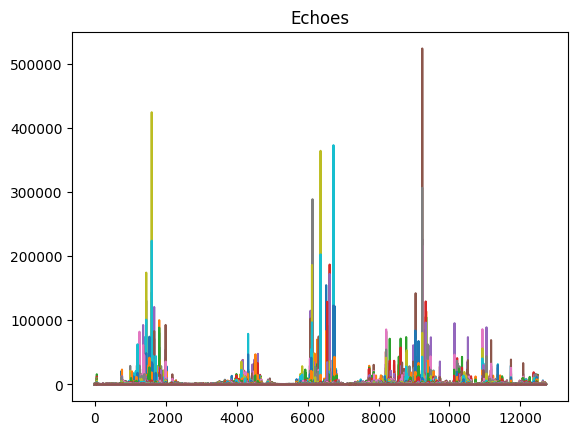

In [ ]:
# Plotting all echoes in the dataset (n=12717)
plt.plot(waves)
plt.title('Echoes')
plt.savefig('/content/drive/MyDrive/GEOL0069/EOYA/waves_all.png')
plt.show()

Plotting all the echoes reveal a huge variability between the echoes in terms of the peakiness and the position at which they peak. These features are used by the algorithm to distinguish different classes.

In [ ]:
waves.shape

(12717, 256)

In [ ]:
flag.shape

(12717,)

There are some NaN values in the dataset so one way to deal with this is to delete them. If there is any NaN values in any column, the whole row will be deleted.

In [5]:
nan_count = np.isnan(data_normalized).sum()
print(f"Number of NaN values in the array: {nan_count}")
data_cleaned = data_normalized[~np.isnan(data_normalized).any(axis=1)]
flag_cleaned = flag[~np.isnan(data_normalized).any(axis=1)]
waves_cleaned = waves[~np.isnan(data_normalized).any(axis=1)]
# lat_cleaned = SAR_lat[~np.isnan(data_normalized).any(axis=1)]
# lon_cleaned = SAR_lon[~np.isnan(data_normalized).any(axis=1)]

Number of NaN values in the array: 945


In [ ]:
data_cleaned.shape

(12042, 3)

In [ ]:
waves_cleaned.shape

(12042, 256)

In [ ]:
flag_cleaned.shape

(12042,)

Next, we want to take into account just the pixels that are classified as either sea ice or lead by ESA so we can directly compare the results afterwards. flag_cleaned==1 and flag_cleaned==2 are the labels for sea ice and lead respectively. Therefore, we are identifying which pixels are asociated with them for data_cleaned and waves_cleaned. Remember that from this point forward, our variables do not include the whole dataset.

In [6]:
data_cleaned = data_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
waves_cleaned = waves_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
flag_cleaned = flag_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]

In [ ]:
data_cleaned.shape

(6508, 3)

# K-means Unsupervised Classification
K-means unsupervised classificaton is applied to the cleaned altimetry data to distinguish lead and sea ice (number of clusters=2).

In [7]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(data_cleaned)
clusters_kmeans = kmeans.predict(data_cleaned)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
clusters_kmeans.shape

(6508,)

In [8]:
unique, counts = np.unique(clusters_kmeans, return_counts=True)
class_counts = dict(zip(unique, counts))

print(class_counts)
# 0: sea ice
# 1: lead

{0: 4197, 1: 2311}


## Sea ice analysis

In [ ]:
waves_cleaned[clusters_kmeans==0].shape  # 4197 sea ice pixels

(4197, 256)

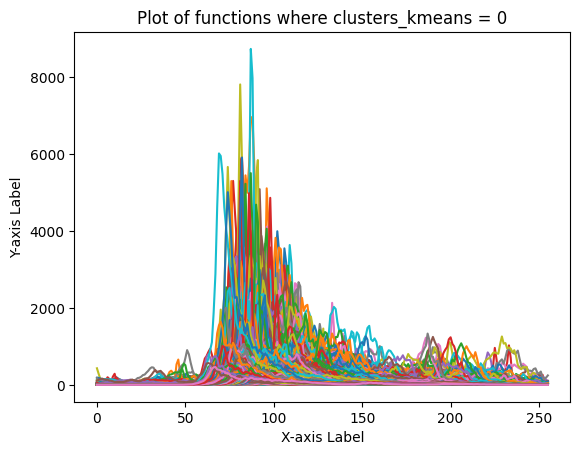

In [ ]:
# All functions where clusters_kmeans is equal to 0
functions_to_plot = waves_cleaned[clusters_kmeans == 0]

# Plot each function
for i, function in enumerate(functions_to_plot):
    plt.plot(function)#, label=f'Function {i+1}')

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Plot of functions where clusters_kmeans = 0')
# plt.legend()
plt.savefig('/content/drive/MyDrive/GEOL0069/EOYA/ice_all.png')
plt.show()

Analysing all echoes would be too messy and computationally intensive. So, we will extract a part of the data to aid visualisation. We could take the first 10 or the last 20 echoes, but that would not be representative of the whole dataset. Therefore, for each class we will extract 15 equally spaced echoes across the dataset.

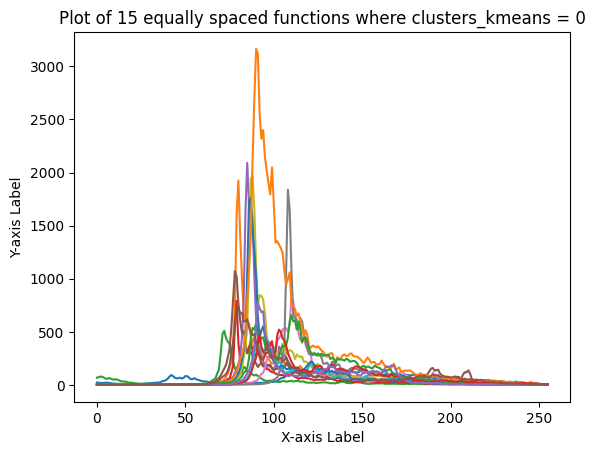

In [ ]:
# Extract 15 equally spaced functions where clusters_kmeans is equal to 0
functions_to_plot = waves_cleaned[clusters_kmeans == 0][::len(waves_cleaned[clusters_kmeans == 0]) // 15]

# Plot each function
for i, function in enumerate(functions_to_plot):
    plt.plot(function)#, label=f'Function {i+1}')

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Plot of 15 equally spaced functions where clusters_kmeans = 0')
# plt.legend()
plt.savefig('/content/drive/MyDrive/GEOL0069/EOYA/ice_example.png')
plt.show()

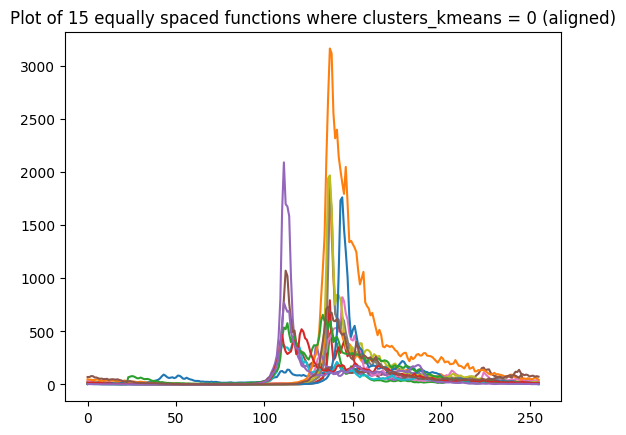

In [ ]:
from scipy.signal import correlate

# Find the reference point (e.g., the peak)
reference_point_index = np.argmax(np.mean(waves_cleaned[clusters_kmeans==0], axis=0))

# Calculate cross-correlation with the reference point
aligned_waves_ice = []
for wave in waves_cleaned[clusters_kmeans==0][::len(waves_cleaned[clusters_kmeans == 0]) // 15]:
    correlation = correlate(wave, waves_cleaned[clusters_kmeans==0][0])
    shift = len(wave) - np.argmax(correlation)
    aligned_wave = np.roll(wave, shift)
    aligned_waves_ice.append(aligned_wave)

# Plot aligned waves
for aligned_wave in aligned_waves_ice:
    plt.plot(aligned_wave)

plt.title('Plot of 15 equally spaced functions where clusters_kmeans = 0 (aligned)')
plt.show()

## Lead analysis

In [ ]:
waves_cleaned[clusters_kmeans==1].shape  # 2311 lead pixels

(2311, 256)

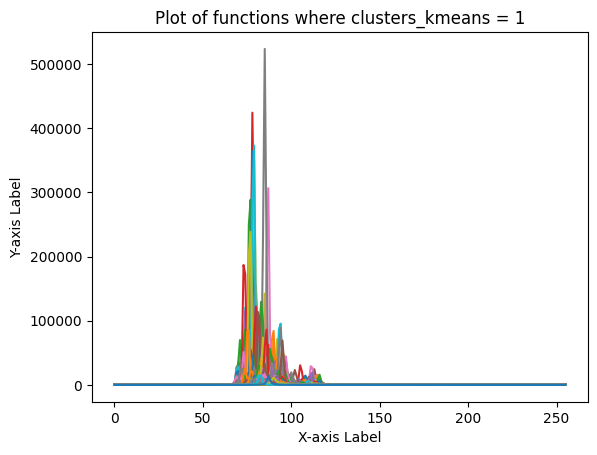

In [ ]:
# All functions where clusters_kmeans is equal to 1
functions_to_plot = waves_cleaned[clusters_kmeans == 1]

# Plot each function
for i, function in enumerate(functions_to_plot):
    plt.plot(function)#, label=f'Function {i+1}')

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Plot of functions where clusters_kmeans = 1')
# plt.legend()
plt.savefig('/content/drive/MyDrive/GEOL0069/EOYA/lead_all.png')

plt.show()

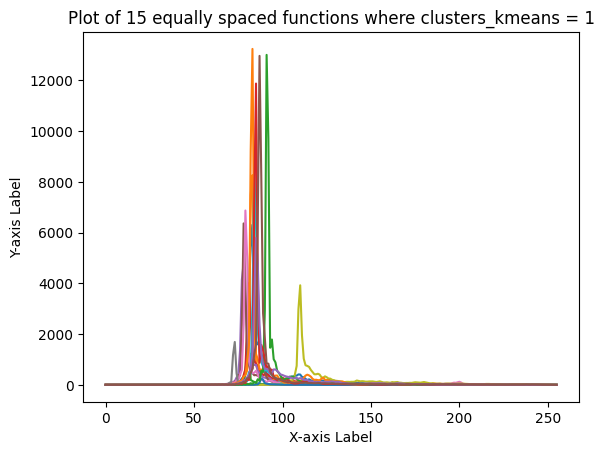

In [ ]:
# Extract 15 equally spaced functions where clusters_kmeans is equal to 1
functions_to_plot = waves_cleaned[clusters_kmeans == 1][::len(waves_cleaned[clusters_kmeans == 1]) // 15]

# Plot each function
for i, function in enumerate(functions_to_plot):
    plt.plot(function)#, label=f'Function {i+1}')

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Plot of 15 equally spaced functions where clusters_kmeans = 1')
# plt.legend()
plt.savefig('/content/drive/MyDrive/GEOL0069/EOYA/lead_example.png')
plt.show()

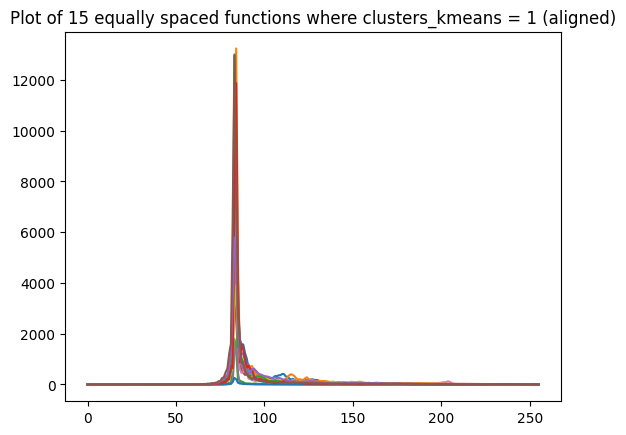

In [ ]:
# Find the reference point (e.g., the peak)
reference_point_index = np.argmax(np.mean(waves_cleaned[clusters_kmeans==1], axis=0))

# Calculate cross-correlation with the reference point
aligned_waves_lead = []
for wave in waves_cleaned[clusters_kmeans==1][::len(waves_cleaned[clusters_kmeans == 1]) // 15]:
    correlation = correlate(wave, waves_cleaned[clusters_kmeans==1][0])
    shift = len(wave) - np.argmax(correlation)
    aligned_wave = np.roll(wave, shift)
    aligned_waves_lead.append(aligned_wave)

# Plot aligned waves
for aligned_wave in aligned_waves_lead:
    plt.plot(aligned_wave)

plt.title('Plot of 15 equally spaced functions where clusters_kmeans = 1 (aligned)')
plt.show()

## Mean and standard deviation

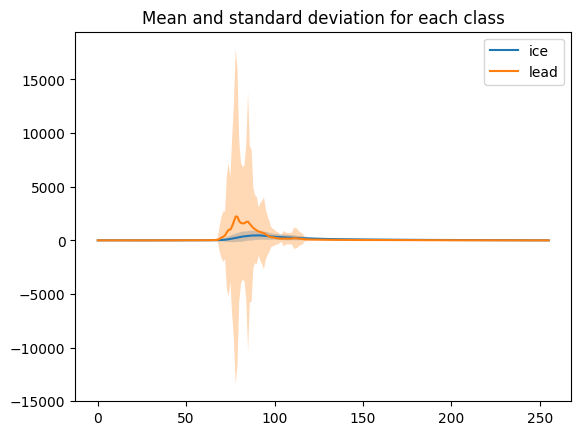

In [ ]:
# Echoes are not aligned
mean_ice = np.mean(waves_cleaned[clusters_kmeans==0],axis=0)
std_ice = np.std(waves_cleaned[clusters_kmeans==0], axis=0)

plt.plot(mean_ice, label='ice')
plt.fill_between(range(len(mean_ice)), mean_ice - std_ice, mean_ice + std_ice, alpha=0.3)

mean_lead = np.mean(waves_cleaned[clusters_kmeans==1],axis=0)
std_lead = np.std(waves_cleaned[clusters_kmeans==1], axis=0)

plt.plot(mean_lead, label='lead')
plt.fill_between(range(len(mean_lead)), mean_lead - std_lead, mean_lead + std_lead, alpha=0.3)

plt.title('Mean and standard deviation for each class')
plt.legend()
plt.savefig('/content/drive/MyDrive/GEOL0069/EOYA/mean_sd.png')


In [ ]:
from scipy.signal import correlate

# Find the reference point (e.g., the peak)
reference_point_index = np.argmax(np.mean(waves_cleaned[clusters_kmeans==0], axis=0))    # ice

# Calculate cross-correlation with the reference point
aligned_waves_ice = []
for wave in waves_cleaned[clusters_kmeans==0]:
    correlation = correlate(wave, waves_cleaned[clusters_kmeans==0][0])
    shift = len(wave) - np.argmax(correlation)
    aligned_wave = np.roll(wave, shift)
    aligned_waves_ice.append(aligned_wave)


# Find the reference point (e.g., the peak)
reference_point_index = np.argmax(np.mean(waves_cleaned[clusters_kmeans==1], axis=0))    # lead

# Calculate cross-correlation with the reference point
aligned_waves_lead = []
for wave in waves_cleaned[clusters_kmeans==1]:
    correlation = correlate(wave, waves_cleaned[clusters_kmeans==1][0])
    shift = len(wave) - np.argmax(correlation)
    aligned_wave = np.roll(wave, shift)
    aligned_waves_lead.append(aligned_wave)



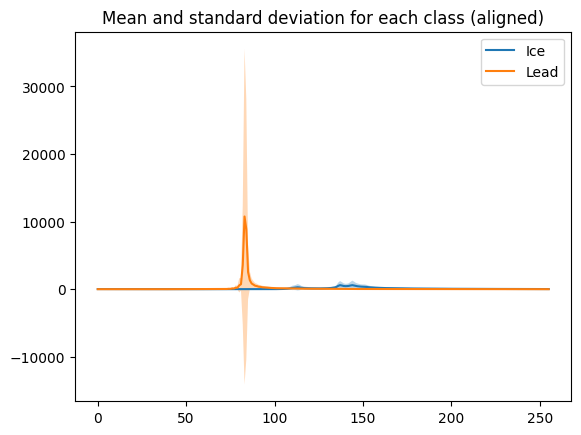

In [ ]:
# Assuming aligned_waves is a list of arrays, where each array is an aligned wave
aligned_waves_ice = np.array(aligned_waves_ice)
aligned_waves_lead = np.array(aligned_waves_lead)

# Calculate the mean of the aligned waves along the 0th axis (i.e., mean for each point in time)
mean_ice = np.mean(aligned_waves_ice,axis=0)
std_ice = np.std(aligned_waves_ice, axis=0)
plt.plot(mean_ice, label='Ice')
plt.fill_between(range(len(mean_ice)), mean_ice - std_ice, mean_ice + std_ice, alpha=0.3)

mean_lead = np.mean(aligned_waves_lead,axis=0)
std_lead = np.std(aligned_waves_lead, axis=0)
plt.plot(mean_lead, label='Lead')
plt.fill_between(range(len(mean_lead)), mean_lead - std_lead, mean_lead + std_lead, alpha=0.3)

# Plot the mean of the aligned waves
plt.legend()
plt.title('Mean and standard deviation for each class (aligned)')
plt.savefig('/content/drive/MyDrive/GEOL0069/EOYA/mean_sd_aligned.png')
plt.show()


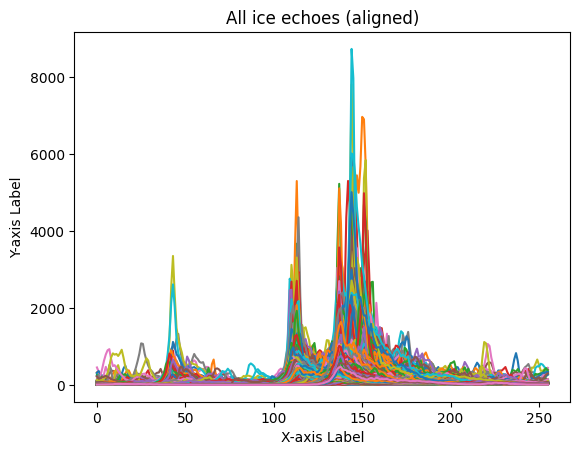

In [ ]:
functions_to_plot = aligned_waves_ice

# Plot each function
for i, function in enumerate(functions_to_plot):
    plt.plot(function)#, label=f'Function {i+1}')

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('All ice echoes (aligned)')
# plt.legend()
plt.savefig('/content/drive/MyDrive/GEOL0069/EOYA/ice_all_aligned.png')
plt.show()

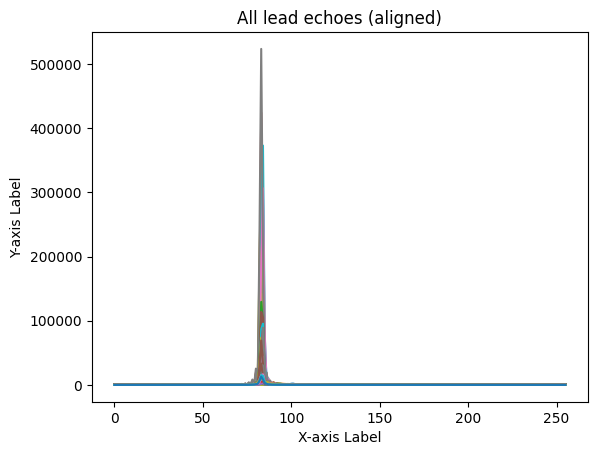

In [ ]:
functions_to_plot = aligned_waves_lead

# Plot each function
for i, function in enumerate(functions_to_plot):
    plt.plot(function)#, label=f'Function {i+1}')

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('All lead echoes (aligned)')
# plt.legend()
plt.savefig('/content/drive/MyDrive/GEOL0069/EOYA/lead_all_aligned.png')
plt.show()

# Confusion Matrix
In the ESA dataset, sea ice = 1 and lead = 2. Therefore, the array is modified so that the labelling we use for all datsets are consistent where sea ice = 0 and lead = 1. Confusion matrices can now be produced to compare the results from k-means clustering with the ESA classification (ground truth).

In [10]:
flag_cleaned_modified = flag_cleaned - 1

In [11]:
unique, counts = np.unique(flag_cleaned_modified, return_counts=True)
class_counts = dict(zip(unique, counts))

print(class_counts)  # ESA dataset --- 4180 seaice, 2328 lead

{0.0: 4180, 1.0: 2328}


In [12]:
from sklearn.metrics import confusion_matrix, classification_report

true_labels = flag_cleaned_modified      # true labels from the ESA dataset
predicted_kmeans = clusters_kmeans       # predicted labels from k-means method

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_kmeans)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Compute classification report
class_report = classification_report(true_labels, predicted_kmeans)

# Print classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[4174    6]
 [  23 2305]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      4180
         1.0       1.00      0.99      0.99      2328

    accuracy                           1.00      6508
   macro avg       1.00      0.99      1.00      6508
weighted avg       1.00      1.00      1.00      6508



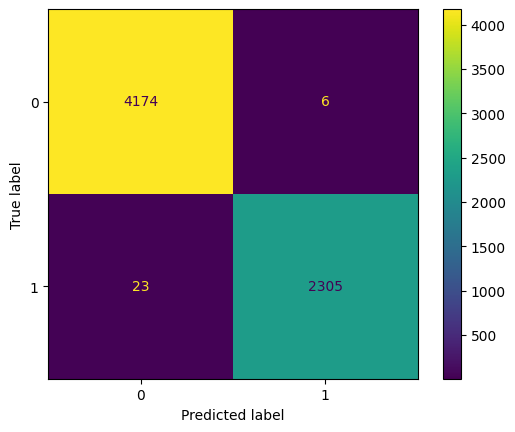

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.savefig('/content/drive/MyDrive/GEOL0069/EOYA/confusion_matrix.png')
plt.show()